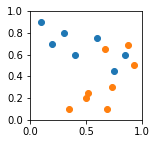

In [2]:
import numpy as np
from matplotlib import pyplot as plt

x = np.array([
    [0.1, 0.9],
    [0.2, 0.7],
    [0.3, 0.8],
    [0.4, 0.6],
    [0.6, 0.75],
    [0.75, 0.45],
    [0.85, 0.6], #
    [0.35, 0.1],
    [0.5, 0.2],
    [0.52, 0.25],
    [0.67, 0.65],
    [0.69, 0.1],
    [0.73, 0.3],
    [0.88, 0.69],
    [0.93, 0.5]
])

y = np.array([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0])

plt.figure(figsize=(2, 2))
plt.scatter(x[:, 0][y==1], x[:, 1][y==1])
plt.scatter(x[:, 0][y==0], x[:, 1][y==0])
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.show()

In [3]:
from sklearn.linear_model import LogisticRegression

linear = LogisticRegression(penalty='none', fit_intercept=False)
linear.fit(x, y)
linear.coef_

array([[-6.3867975 ,  7.78664672]])

In [4]:
from pygam import LogisticGAM
from pygam import s

lam = np.logspace(-3, 5, 5)
lams = [lam] * 2

gam = LogisticGAM(s(0, n_splines=10)+s(1, n_splines=10), fit_intercept=True, lam=0.5, max_iter=500)
gam.fit(x, y)
# gam.gridsearch(x, y, lam=lams)

LogisticGAM(callbacks=[Deviance(), Diffs(), Accuracy()], 
   fit_intercept=True, max_iter=500, terms=s(0) + s(1) + intercept, 
   tol=0.0001, verbose=False)

In [5]:
gam.coef_

array([-0.15493344,  0.45062251,  0.67045623,  0.41429961, -0.06361929,
       -0.46723449, -0.62005706, -0.50453939, -0.2539721 ,  0.36497945,
        0.44732117, -0.8139955 , -1.39481742, -1.06433587, -0.20253578,
        0.56275585,  1.0010816 ,  1.12088018,  0.59305408, -0.41340631,
       -0.16399798])

In [6]:
from realkd.rules import RuleBoostingEstimator, XGBRuleEstimator, logistic_loss
import pandas as pd

x_df = pd.DataFrame(x, columns=['x1', 'x2'])
y_df = pd.Series(y)

rules = RuleBoostingEstimator(base_learner=XGBRuleEstimator(loss=logistic_loss), verbose=1)
rules.fit(x_df, y_df)


   +0.8750 if x2>=0.24000000000000002
   +0.5561 if x2>=0.24000000000000002
   +0.4043 if x2>=0.24000000000000002


RuleBoostingEstimator(max_rules=3, base_learner=XGBRuleEstimator(reg=1.0, loss=logistic))

In [7]:
from rulefit import RuleFit

rules = RuleFit(rfmode='classify', model_type='r')
rules.fit(x, y, feature_names=['x1', 'x2'])
# rules.get_rules()[rules.get_rules()['coef']>0]


rules_ = rules.get_rules()
rules_ = rules_[rules_.coef != 0].sort_values("importance", ascending=False)[:3]
rules_

,rule,type,coef,support,importance
292,x1 <= 0.7400000095367432 & x2 <= 0.69999998807...,rule,-1.419729,0.428571,0.702584
467,x2 > 0.375 & x1 <= 0.8650000095367432,rule,0.982326,0.428571,0.486125
465,x2 > 0.3499999940395355 & x1 <= 0.865000009536...,rule,0.861829,0.571429,0.426495


In [40]:
r3 = rules_.iloc[2]
r3.rule

'x1 <= 0.8650000095367432 & x2 > 0.3499999940395355'

In [8]:
def r1(x):
    return -1.3*((x[:, 0] <= 0.74) & (x[:, 0] > 0.46))

def r2(x):
    return 1.8*((x[:, 1] > 0.425) & (x[:,0]<=0.865))

def r3(x):
    return 0.92*((x[:, 1] > 0.35) & (x[:,0]<=0.865))

def f_rules(x):
    return r1(x)+r2(x)+r3(x)

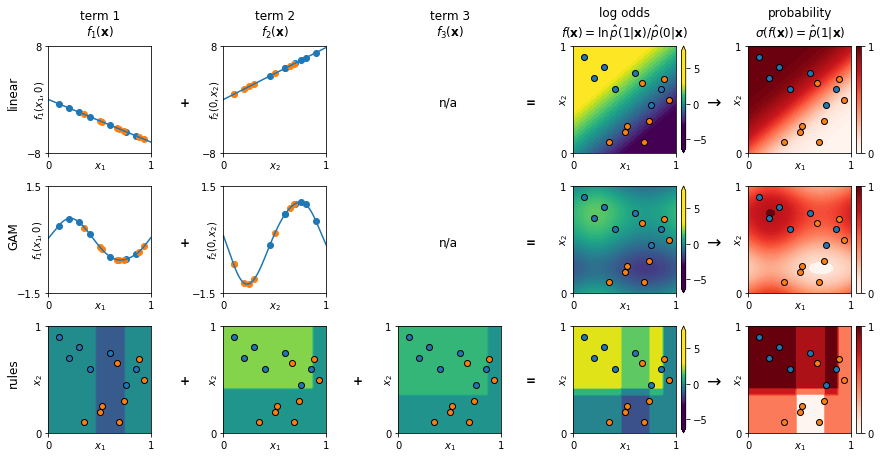

In [76]:
from matplotlib import pyplot as plt
from matplotlib.text import Text
from common import OUTPUTPATH
import os

xx1d = np.linspace(0, 1, 50)
xx1, xx2 = np.meshgrid(np.linspace(0, 1, 50), np.linspace(0, 1, 50))
xx = np.column_stack((xx1.ravel(), xx2.ravel()))

def f(x1, x2):
    return -6.3867975*x1 + 7.78664672*x2

def sigma(a):
    return 1/(1+np.exp(-a))

def logit(p):
    return np.log(p/(1-p))

def prepare_xaxis(ax, label, a=0, b=1):
    ax.set_xlabel(label, labelpad=-10)
    ax.set_xticks([a, b])
    ax.set_xlim(a, b)

def prepare_yaxis(ax, label, a=0, b=1, pad=-10):
    ax.set_ylabel(label, labelpad=pad)
    ax.set_yticks([a, b])
    ax.set_ylim(a, b)

def plot_data(ax):
    ax.scatter(x[:, 0][y==1], x[:, 1][y==1], ec='black')
    ax.scatter(x[:, 0][y==0], x[:, 1][y==0], ec='black')

def external_colorbar(mappable, ax, ticks=None):
    bbox = ax.get_position()
    cax = plt.axes([bbox.x1+0.05*(bbox.x1-bbox.x0), bbox.y0, 0.005, bbox.y1 - bbox.y0])
    res = plt.colorbar(mappable, cax=cax)
    if ticks is not None: res.set_ticks(ticks)
    return res

vmin_lo, vmax_lo = -3, 3

fig, axs = plt.subplots(3, 5, figsize=(12, 6))
fig.tight_layout(w_pad=3.5, pad=1.2) #, rect=(0.05, 0, 1, 1)
# fig.subplots_adjust(left=-0.2)
axs[0, 0].plot(np.linspace(0, 1, 50), -6.3867975*np.linspace(0, 1, 50))
axs[0, 0].scatter(x[:, 0][y==1], -6.3867975*x[:, 0][y==1])
axs[0, 0].scatter(x[:, 0][y==0], -6.3867975*x[:, 0][y==0])
prepare_xaxis(axs[0, 0], '$x_1$', 0, 1)
prepare_yaxis(axs[0, 0], '$f_1(x_1, 0)$', -8, 8, -20)
axs[0, 1].plot(np.linspace(0, 1, 50), 7.78664672*np.linspace(0, 1, 50))
axs[0, 1].scatter(x[:, 1][y==1], 7.78664672*x[:, 1][y==1])
axs[0, 1].scatter(x[:, 1][y==0], 7.78664672*x[:, 1][y==0])
prepare_xaxis(axs[0, 1], '$x_2$', 0, 1)
prepare_yaxis(axs[0, 1], '$f_2(0, x_2)$', -8, 8, -20)
# axs[0, 2].set_visible(False)
# axs[0, 2].get_xaxis().set_visible(False)
# axs[0, 2].get_yaxis().set_visible(False)
axs[0, 2].set_axis_off()

ctp_linear = axs[0, 3].contourf(xx1, xx2, f(xx1, xx2), levels=50, vmin=vmin_lo, vmax=vmax_lo, extend='both')
external_colorbar(ctp_linear, axs[0, 3], ticks=[-5, 0, 5])
plot_data(axs[0, 3])
prepare_xaxis(axs[0, 3], '$x_1$')
prepare_yaxis(axs[0, 3], '$x_2$')

ctp_linear_probs = axs[0, 4].contourf(xx1, xx2, sigma(f(xx1, xx2)), levels=50, cmap='Reds', vmin=0, vmax=1)
external_colorbar(ctp_linear_probs, axs[0, 4], ticks=[0, 1])
plot_data(axs[0, 4])
prepare_xaxis(axs[0, 4], '$x_1$')
prepare_yaxis(axs[0, 4], '$x_2$')


# xx_gam = gam.generate_X_grid(term=0)
xx_gam = np.zeros(shape=(100, 2), dtype=float)
xx_gam[:, 0] = np.linspace(0, 1, 100)
axs[1, 0].plot(xx_gam[:, 0], gam.partial_dependence(0, X=xx_gam))
axs[1, 0].scatter(x[:, 0][y==1], gam.partial_dependence(0, X=x[y==1]))
axs[1, 0].scatter(x[:, 0][y==0], gam.partial_dependence(0, X=x[y==0]))
prepare_xaxis(axs[1, 0], '$x_1$')
prepare_yaxis(axs[1, 0], '$f_1(x_1, 0)$', -1.5, 1.5, -28)

# xx_gam = gam.generate_X_grid(term=1)
xx_gam = np.zeros(shape=(100, 2), dtype=float)
xx_gam[:, 1] = np.linspace(0, 1, 100)
axs[1, 1].plot(xx_gam[:, 1], gam.partial_dependence(1, X=xx_gam))
axs[1, 1].scatter(x[:, 1][y==1], gam.partial_dependence(1, X=x[y==1]))
axs[1, 1].scatter(x[:, 1][y==0], gam.partial_dependence(1, X=x[y==0]))
prepare_xaxis(axs[1, 1], '$x_2$')
prepare_yaxis(axs[1, 1], '$f_2(0, x_2)$', -1.5, 1.5, -28)

axs[1, 2].set_visible(False)
ctp_gam = axs[1, 3].contourf(xx1, xx2, logit(gam.predict_proba(xx)).reshape(50, 50), levels=50, vmin=vmin_lo, vmax=vmax_lo)
external_colorbar(ctp_linear, axs[1, 3], ticks=[-5, 0, 5])
plot_data(axs[1, 3])
prepare_xaxis(axs[1, 3], '$x_1$')
prepare_yaxis(axs[1, 3], '$x_2$')

ctp_gam_probs = axs[1, 4].contourf(xx1, xx2, gam.predict_proba(xx).reshape(50, 50), levels=50, cmap='Reds', vmin=0, vmax=1, extend='both')
external_colorbar(ctp_linear_probs, axs[1, 4], ticks=[0, 1])
plot_data(axs[1, 4])
prepare_xaxis(axs[1, 4], '$x_1$')
prepare_yaxis(axs[1, 4], '$x_2$')

axs[2, 0].contourf(xx1, xx2, r1(xx).reshape(50, 50), vmin=vmin_lo, vmax=vmax_lo)
axs[2, 1].contourf(xx1, xx2, r2(xx).reshape(50, 50), vmin=vmin_lo, vmax=vmax_lo)
axs[2, 2].contourf(xx1, xx2, r3(xx).reshape(50, 50), vmin=vmin_lo, vmax=vmax_lo)
ctp_rules = axs[2, 3].contourf(xx1, xx2, f_rules(xx).reshape(50, 50), vmin=vmin_lo, vmax=vmax_lo)
cbr_rules = external_colorbar(ctp_linear, axs[2, 3])
cbr_rules.set_ticks([-5, 0, 5])
ctp_rule_probs = axs[2, 4].contourf(xx1, xx2, sigma(f_rules(xx)).reshape(50, 50), cmap='Reds', vmin=0, vmax=1, extend='both')
external_colorbar(ctp_linear_probs, axs[2, 4], [0, 1])

for j in range(5):
    axs[2, j].scatter(x[:, 0][y==1], x[:, 1][y==1], ec='black')
    axs[2, j].scatter(x[:, 0][y==0], x[:, 1][y==0], ec='black')
    prepare_xaxis(axs[2, j], '$x_1$')
    prepare_yaxis(axs[2, j], '$x_2$')

axs[0, 0].set_title(f'term 1\n$f_1(\mathbf{{x}})$', pad=10)
axs[0, 1].set_title('term 2\n$f_2(\mathbf{x})$', pad=10)
axs[0, 2].set_title('term 3\n$f_3(\mathbf{x})$', pad=10)
axs[0, 3].set_title(f'log odds\n$f(\mathbf{{x}}) = \ln \hat{{p}}(1 | \mathbf{{x}})/\hat{{p}}(0 | \mathbf{{x}})$', pad=10)
axs[0, 4].set_title(f'probability\n$\sigma(f(\mathbf{{x}})) = \hat{{p}}(1 | \mathbf{{x}})$', pad=10)

fig.add_artist(Text(0, 0.8245, 'linear', rotation=90, fontsize='large'))
fig.add_artist(Text(0, 0.5, 'GAM', rotation=90, fontsize='large'))
fig.add_artist(Text(0, 0.18, 'rules', rotation=90, fontsize='large'))
fig.add_artist(Text(0.5, 0.8245, 'n/a', fontsize='large'))
fig.add_artist(Text(0.5, 0.5, 'n/a', fontsize='large'))

fig.add_artist(Text(0.2, 0.825, '+', fontsize='large', fontweight='bold'))
fig.add_artist(Text(0.6, 0.825, '=', fontsize='large', fontweight='bold'))
fig.add_artist(Text(0.2, 0.5, '+', fontsize='large', fontweight='bold'))
fig.add_artist(Text(0.6, 0.5, '=', fontsize='large', fontweight='bold'))
fig.add_artist(Text(0.2, 0.18, '+', fontsize='large', fontweight='bold'))
fig.add_artist(Text(0.4, 0.18, '+', fontsize='large', fontweight='bold'))
fig.add_artist(Text(0.6, 0.18, '=', fontsize='large', fontweight='bold'))
# fig.add_artist(Text(0.739, 0.55, r'$\sigma$', fontsize='large', fontweight='bold'))
fig.add_artist(Text(0.805, 0.825, r'$\rightarrow$', fontsize='xx-large', fontweight='bold'))
fig.add_artist(Text(0.805, 0.5, r'$\rightarrow$', fontsize='xx-large', fontweight='bold'))
fig.add_artist(Text(0.805, 0.18, r'$\rightarrow$', fontsize='xx-large', fontweight='bold'))
plt.savefig(os.path.join(OUTPUTPATH, 'models_schematic.pdf'), bbox_inches='tight', pad_inches=0)
plt.show()

In [37]:
bbox.y1

0.31481481481481477